# Financial Mathematics 
### Lab 3: Cox-Ross-Rubenstein model

The purpose of this class is to implement Cox Ross Rubenstein model alongside different payouts (european call option, european put option and max value at trajectory).

In [28]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.special import comb
import seaborn as sns

Implementation idea outline:

Three classes are implemented:
- `Market`: Market model with parameters among time, price increase factor, price decrease factor, bank interest rate, start price. Model simulates price changes tree and visualises it.
- `Payout`: Abstract class defining the payout function. Specific payout types like European call, European put, and maximum trajectory value will inherit from this class. Each class inheriting from Payout implements its own 'call' method which calculates the payout value for given trajectory.
- `CRRModel`: Implements the Cox-Ross-Rubinstein model, calculates recurently the option price using the market model and payout function.

#### Market model

In [29]:
class Market():
    def __init__(self, T: int, up: float, down: float, r: float, start: float):
        """
        Initialize the market parameters.
        T (int): Number of time steps
        up (float): Up factor
        down (float): Down factor
        r (float): interest rate
        start (float): Initial stock price
        """
        self.T = T
        self.up = up
        self.down = down
        self.r = r
        self.start = start
        self.p = (1 + r - down) / (up - down)
        
    def get_stock_price(self, k: int, n: int) -> float:
        return self.start * (self.up ** k) * (self.down ** (n - k))
    
    def draw_binomial_tree(self) -> None:
        G = nx.DiGraph()
        for i in range(self.T + 1):
            for j in range(i + 1):
                G.add_node((i, j), pos=(i, j))
                if i < self.T:
                    G.add_edge((i, j), (i + 1, j + 1), weight=self.up)
                    G.add_edge((i, j), (i + 1, j), weight=self.down)
        
        pos = nx.get_node_attributes(G, 'pos')
        labels = {(i, j): f"{self.get_stock_price(j, i):.2f}" for i, j in G.nodes()}
        plt.figure(figsize=(12, 8))  
        nx.draw(G, pos=pos, with_labels=True, labels=labels, font_size=10, 
            node_color='gold', font_weight='bold', edge_color='lightgray', node_size=1500)
        plt.title("Stock Price Tree")
        plt.show()

#### Payouts

In [30]:
class Payout():
    def __call__(self, trajectory: list) -> float:
        raise NotImplementedError("Payout must implement __call__ method")
    
class PayoutEuropean(Payout):
    def __init__(self, strike: float):
        self.strike = strike
        
    def __call__(self, trajectory: list) -> float:
        return max(0, trajectory[-1] - self.strike)
    
    def set_strike(self, strike: float):
        self.strike = strike

class PayoutEuropeanCall(PayoutEuropean):
    def __init__(self, strike: float):
        self.strike = strike
        
    def __call__(self, trajectory: list) -> float:
        return max(0, trajectory[-1] - self.strike)
    
class PayoutEuropeanPut(PayoutEuropean):
    def __init__(self, strike: float):
        self.strike = strike
        
    def __call__(self, trajectory: list) -> float:
        return max(0, self.strike - trajectory[-1])    

class PayoutMaxTrajectoryValue(Payout):
    def __call__(self, trajectory: list) -> float:
        return max(trajectory)

#### CRR Model

In [31]:
class CRRModel():
    """
    Cox-Ross-Rubinstein model for option pricing.
    
    This model uses a binomial tree to calculate the price of options.
    It recursively calculates the price at each node of the tree.
    """
    def __init__(self, market: Market, payout: Payout):
        """ 
        Initialize the Cox-Ross-Rubinstein model.
        market (Market): The market model
        payout (Payout): The payout structure
        """
        self.market = market
        self.payout = payout
        self.trajectory = [market.start]
        
    def discount(self) -> float:
        if len(self.trajectory) == (self.market.T + 1):
            return self.payout(self.trajectory)
        
        # up
        self.trajectory.append(self.trajectory[-1] * self.market.up)
        price_up = self.discount()
        self.trajectory.pop()
        
        # down
        self.trajectory.append(self.trajectory[-1] * self.market.down)
        price_down = self.discount()
        self.trajectory.pop()
        
        rate = 1 / (1 + self.market.r)
        p = self.market.p
        
        return rate * (p * price_up + (1 - p) * price_down)

### Examples

Example market:
- T = 10
- up = 1.3
- down = 0.8
- r = 0.1
- start price = 100
- (for options) strike = 90

#### European call option

In [32]:
market = Market(10, 1.3, 0.8, 0.1, 100)
eu_call = PayoutEuropeanCall(90)
crr = CRRModel(market, eu_call)
crr.discount()

66.97006486520782

#### European put option

In [33]:
eu_put = PayoutEuropeanPut(90)
crr = CRRModel(market, eu_put)
crr.discount()

1.66896091386562

#### Max price in trajectory as payout function

In [34]:
maxim = PayoutMaxTrajectoryValue()
crr = CRRModel(market, maxim)
crr.discount()

116.87742273846627

### Market visualization

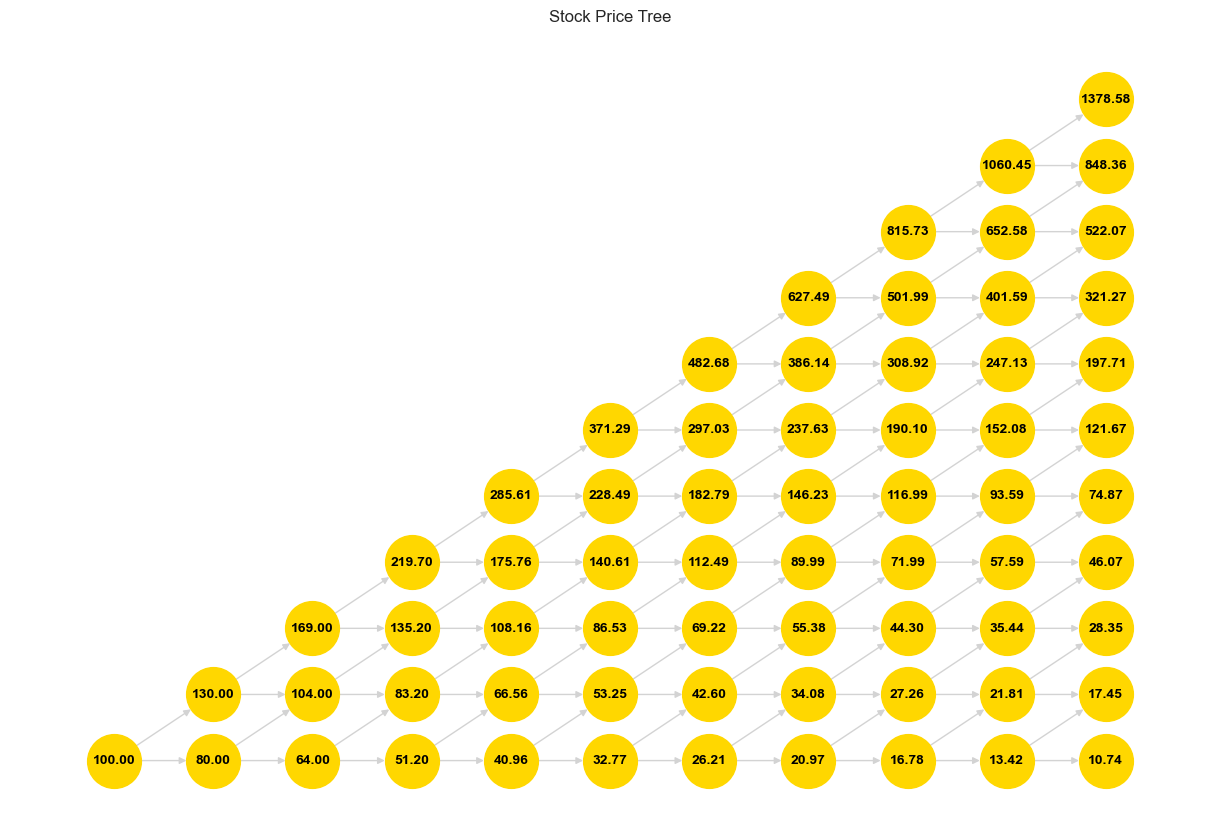

In [35]:
market.draw_binomial_tree()

### Verification 
(for put/call payouts)

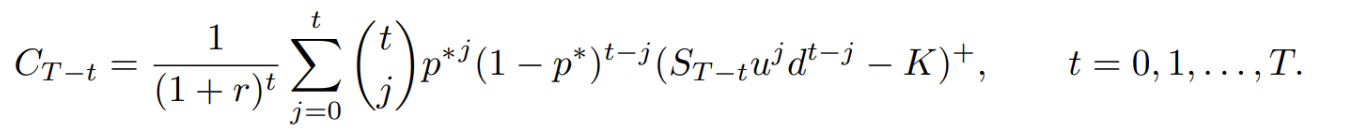

In [36]:
def theoritical_value(market: Market, payout: Payout, t: int) -> float:
        """Computes the option price at time T - t."""
        r = market.r
        S = market.start
        u = market.up
        d = market.down
        p = market.p
        
        discount_factor = (1 / (1 + r)) ** t
        expected_payoff = 0
        
        for j in range(t + 1):
            S_tj = S * (u ** j) * (d ** (t - j))
            payoff = payout([S_tj])
            probability = comb(t, j) * (p ** j) * ((1 - p) ** (t - j))
            expected_payoff += probability * payoff
        
        return discount_factor * expected_payoff

In [37]:
print(f"Theoritical value for European Call Option: {theoritical_value(market, eu_call, 10)}")
print(f"Theoritical value for European Put Option: {theoritical_value(market, eu_put, 10)}")

Theoritical value for European Call Option: 66.97006486520783
Theoritical value for European Put Option: 1.66896091386562


The values match the ones from my model.

### Option payout change in respect to strike

In [40]:
def plot_option_payout_change(T: int,
                              up: float,
                              down: float,
                              r: float,
                              start: float, 
                              strike_min: float,
                              strike_max: float,
                              length: int = 1000) -> None:
    
   
    x = np.arange(strike_min, strike_max, (strike_max - strike_min) / length)
    y, z = np.zeros(length), np.zeros(length)
    for i in range(length):
        market = Market(T, up, down, r, start)
        payout_call = PayoutEuropeanCall(x[i]) 
        crr_call = CRRModel(market, payout_call)
        y[i] = crr_call.discount()
        payout_put = PayoutEuropeanPut(x[i])
        crr_put = CRRModel(market, payout_put)
        z[i] = crr_put.discount()
        
    plt.figure(figsize=(12, 8))    
    sns.lineplot(x=x, y=y, color='blue', label='Call')
    sns.lineplot(x=x, y=z, color='purple', label='Put')
    sns.set_style("whitegrid")
    plt.title(f"Option Payout Change with Strike Price\n"
              f"Market Parameters: T={T}, up={up}, down={down}, r={r}, start={start}")
    plt.legend()
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.show()
    

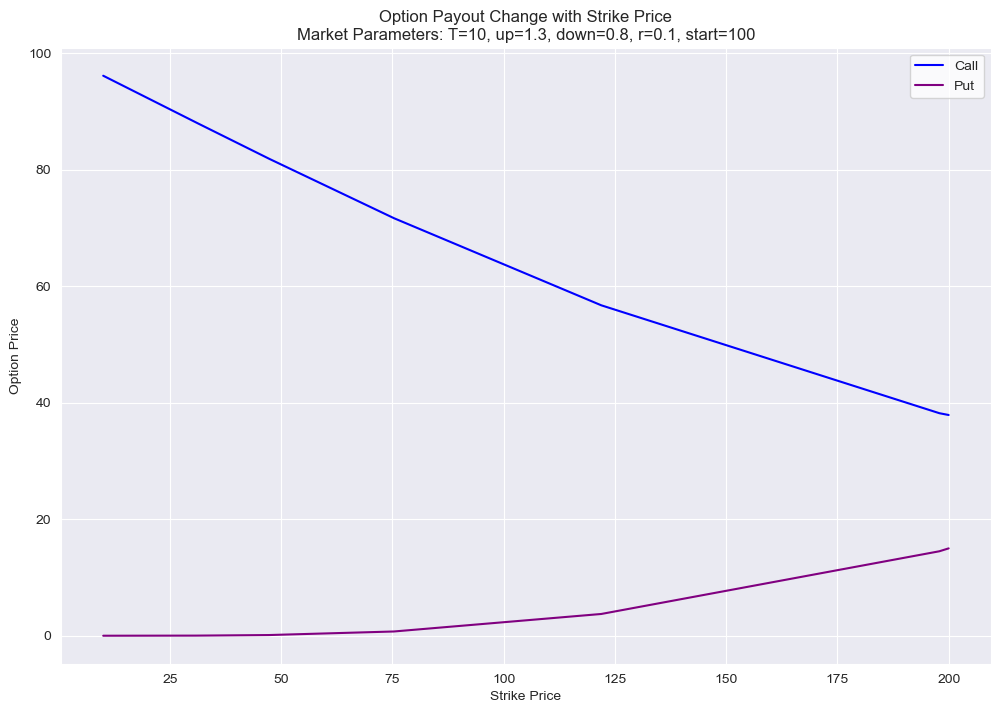

In [41]:
plot_option_payout_change(T = 10,
                        up = 1.3,
                        down = 0.8,
                        r = 0.1,
                        start = 100, 
                        strike_min = 10,
                        strike_max = 200,
                        length = 10_000)